In [40]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from utilities import clip_outliers
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from sklearn.feature_selection import f_classif

# This is a data analysis for the Soybean Cultivars dataset
### add information
### Additional information about the dataset can be found at https://editorapantanal.com.br/journal/index.php/taes/article/view/8/5

In [3]:
data = pd.read_csv('data/data.csv')

In [26]:
data.head()

,Season,Cultivar,Repetition,PH,IFP,NLP,NGP,NGL,NS,MHG,GY
0,1,NEO 760 CE,1,58.80,15.20,98.2,177.80,1.81,5.2,152.20,3232.82
1,1,NEO 760 CE,2,58.60,13.40,102.0,195.00,1.85,7.2,141.69,3517.36
2,1,NEO 760 CE,3,63.40,17.20,100.4,203.00,2.02,6.8,148.81,3391.46
3,1,NEO 760 CE,4,60.27,15.27,100.2,191.93,1.89,6.4,148.50,3312.58
4,1,MANU IPRO,1,81.20,18.00,98.8,173.00,1.75,7.4,145.59,3230.99


# Data cleaning & preprocessing

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Season      320 non-null    int64  
 1   Cultivar    320 non-null    object 
 2   Repetition  320 non-null    int64  
 3   PH          320 non-null    float64
 4   IFP         320 non-null    float64
 5   NLP         320 non-null    float64
 6   NGP         320 non-null    float64
 7   NGL         320 non-null    float64
 8   NS          320 non-null    float64
 9   MHG         320 non-null    float64
 10  GY          320 non-null    float64
dtypes: float64(8), int64(2), object(1)
memory usage: 27.6+ KB


As stated in the dataset documentation there are no missing values and all the columns have the right data type.

In [13]:
data.describe()

,Season,Repetition,PH,IFP,NLP,NGP,NGL,NS,MHG,GY
count,320.000000,320.000000,320.000000,320.0000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,1.500000,2.500000,68.386781,15.4650,59.088313,135.085844,2.290844,4.071656,168.322313,3418.553794
std,0.500783,1.119785,8.958194,3.0243,20.068187,60.494529,0.840116,1.474531,19.625566,503.003602
min,1.000000,1.000000,47.600000,7.2000,20.200000,47.800000,0.940000,0.400000,127.060000,1538.230000
25%,1.000000,1.750000,62.950000,13.6000,44.350000,95.052500,2.000000,3.000000,153.845000,3126.611552
50%,1.500000,2.500000,67.200000,15.6000,54.500000,123.000000,2.280000,3.800000,166.150000,3397.276724
75%,2.000000,3.250000,74.347500,17.3300,71.220000,161.350000,2.480000,5.000000,183.182500,3708.262931
max,2.000000,4.000000,94.800000,26.4000,123.000000,683.400000,14.860000,9.000000,216.000000,4930.000000



From the table above we can see that the maximum number of grains per plant (NGP) and number of legumes per plant (NGL) is very far from the top 75%, so I suspect the presence of outliers.

In [4]:
float_cols = data.select_dtypes(include='float64').columns

mean_and_median = {}
for col in float_cols:
    mean_and_median[col] = {'mean':data[col].mean(), 'median':data[col].median()}
    
mean_and_median

{'PH': {'mean': 68.38678124999998, 'median': 67.2},
 'IFP': {'mean': 15.465000000000003, 'median': 15.6},
 'NLP': {'mean': 59.08831250000001, 'median': 54.5},
 'NGP': {'mean': 135.08584375, 'median': 123.0},
 'NGL': {'mean': 2.29084375, 'median': 2.28},
 'NS': {'mean': 4.07165625, 'median': 3.8},
 'MHG': {'mean': 168.3223125, 'median': 166.15},
 'GY': {'mean': 3418.5537941749994, 'median': 3397.276724}}

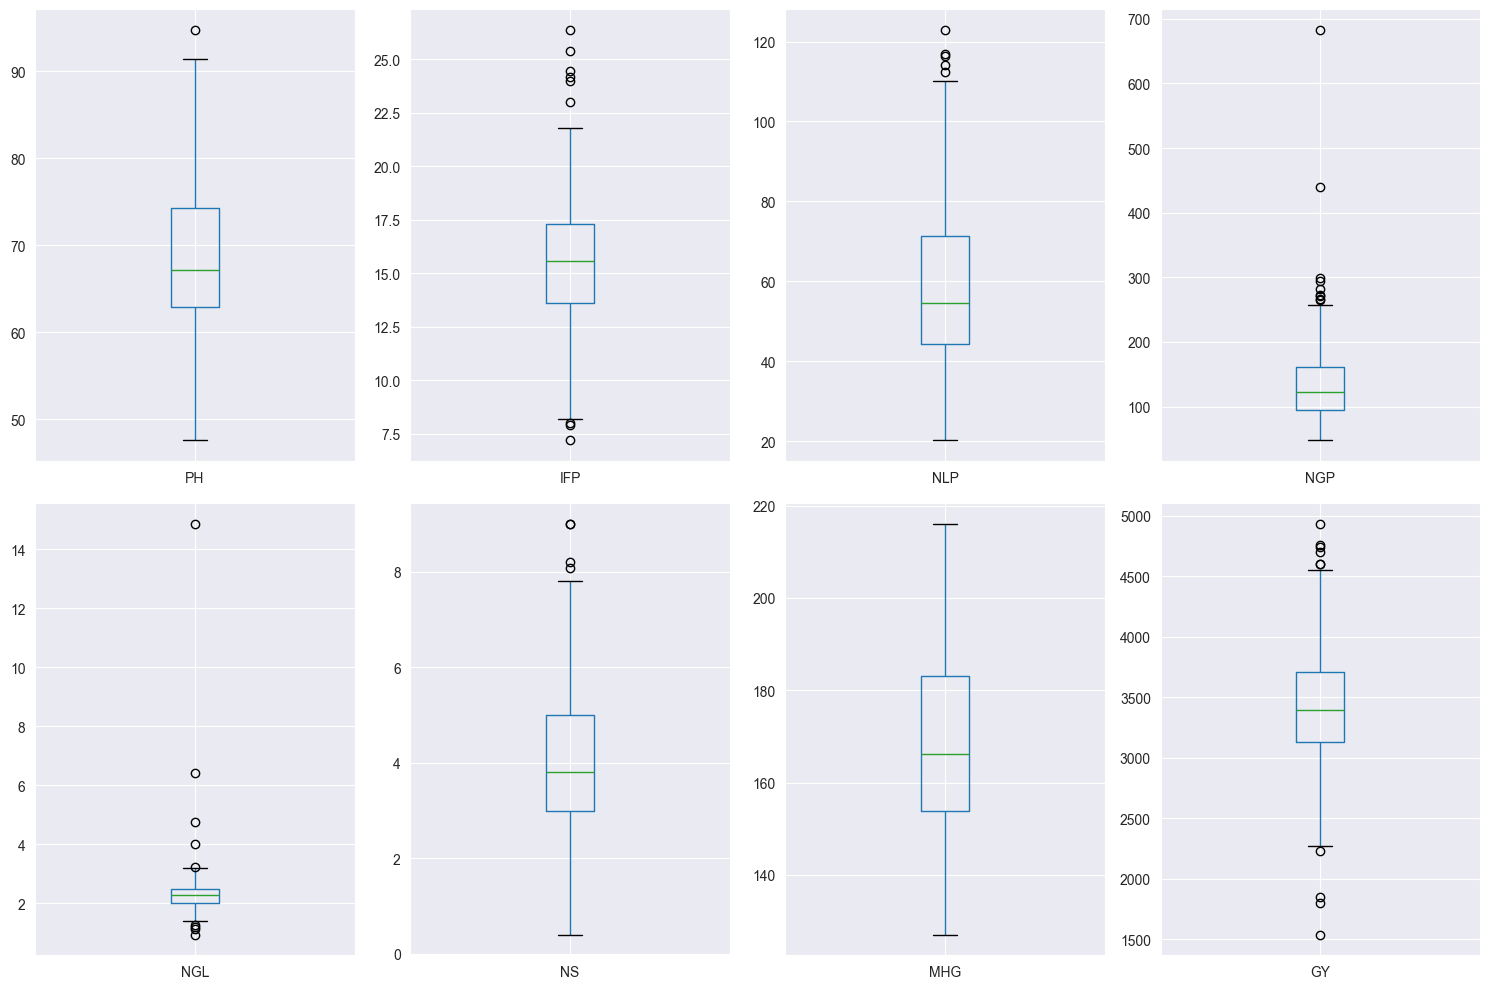

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
cnt = 0
for i in range(2):
    for j in range(4):
        data.boxplot(column=float_cols.tolist()[cnt], ax=axs[i,j])
        cnt += 1
fig.tight_layout()
plt.show()

The boxplots comfirm outliers existence. We can also see them from the histograms below. Before applying any ML model we will get rid of the outliers and transform the distributions in order to get the normal one and not be skewed.

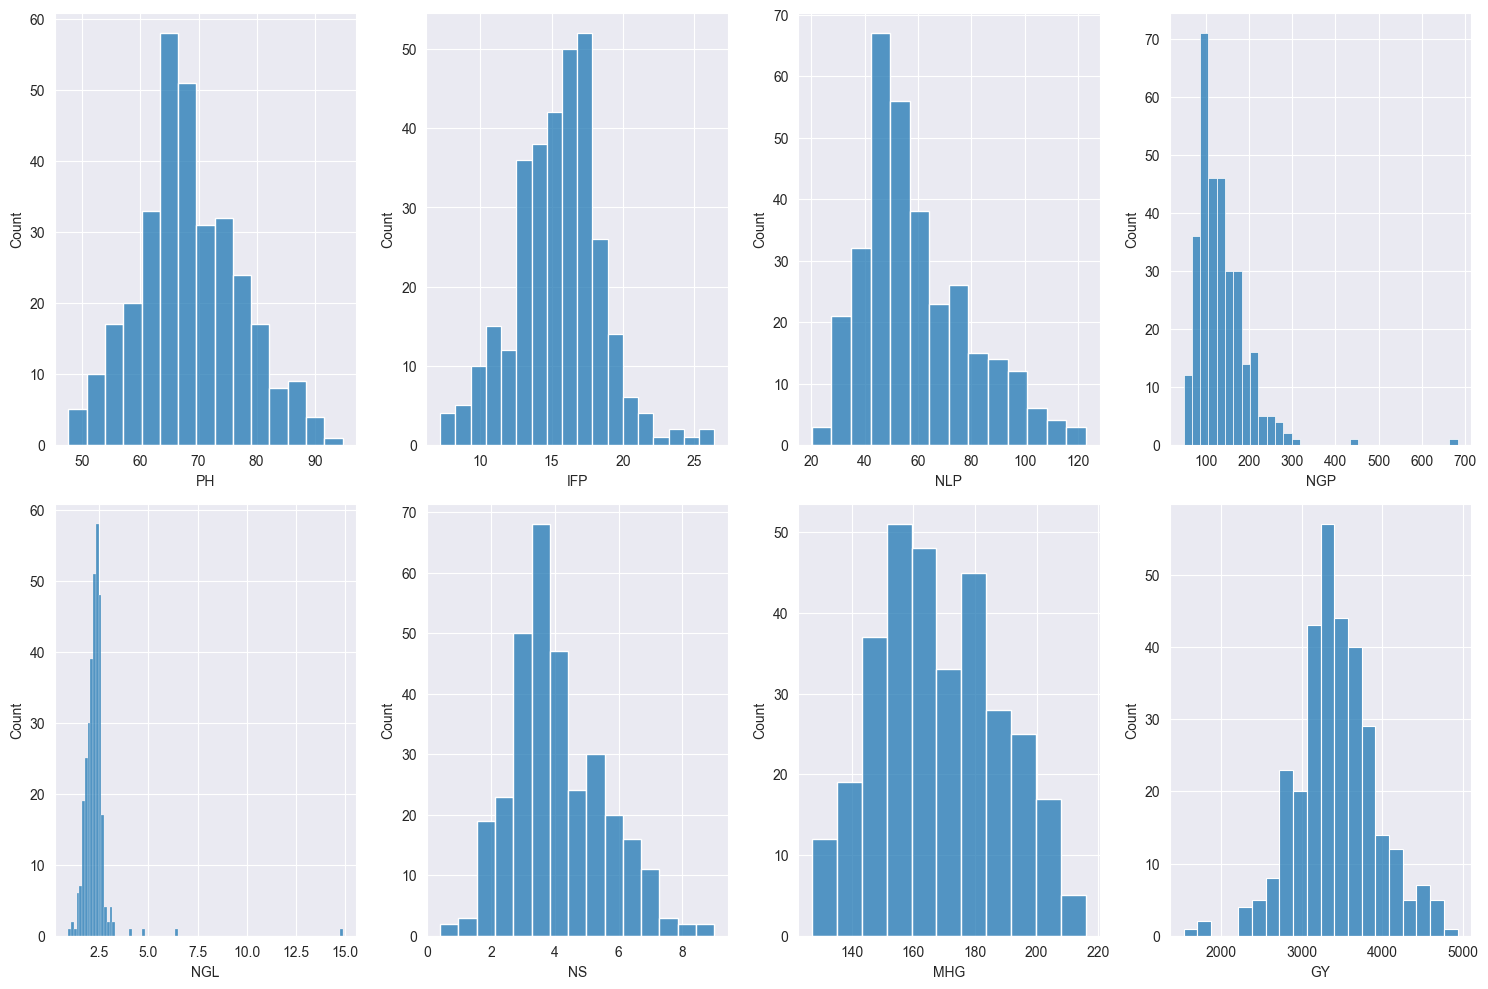

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
cnt = 0
for i in range(2):
    for j in range(4):
        # data.hist(column=float_cols.tolist()[cnt], ax=axs[i,j], sharex=False, sharey=False, bins=30)
        sns.histplot(data[float_cols.tolist()[cnt]], ax=axs[i,j])
        cnt += 1
fig.tight_layout()
plt.show()

In [18]:
season1 = data[data.Season == 1]
season2 = data[data.Season == 2]

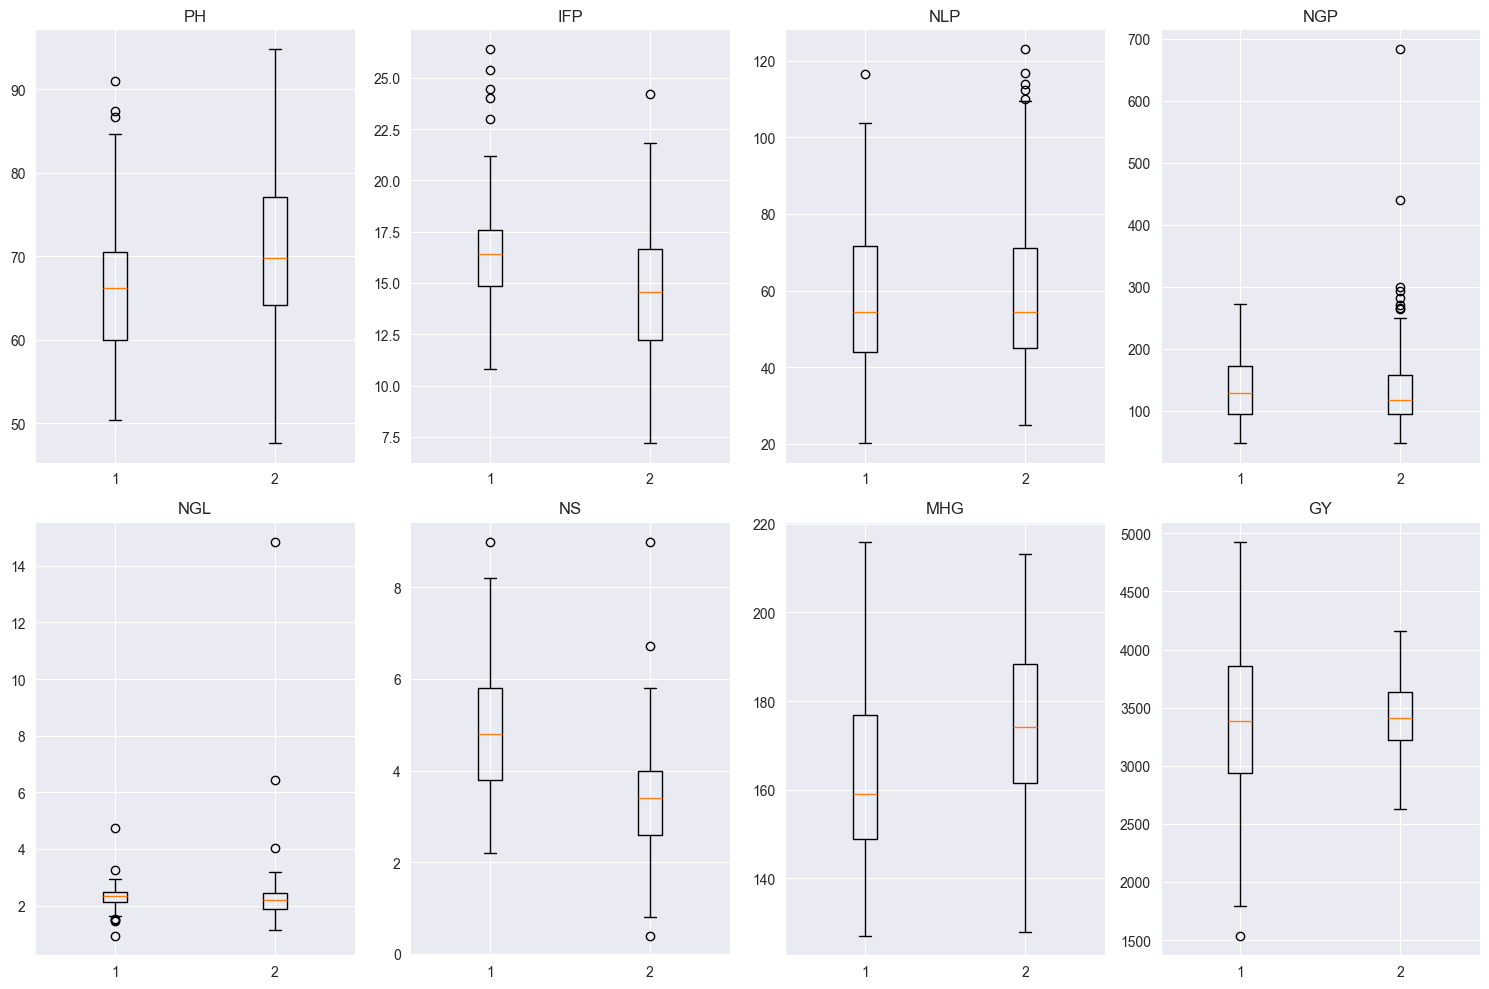

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
cnt = 0
for i in range(2):
    for j in range(4):
        axs[i, j].boxplot([season1[float_cols.tolist()[cnt]], season2[float_cols.tolist()[cnt]]])
        axs[i, j].set_title(float_cols.tolist()[cnt])
        cnt += 1
fig.tight_layout()
plt.show()

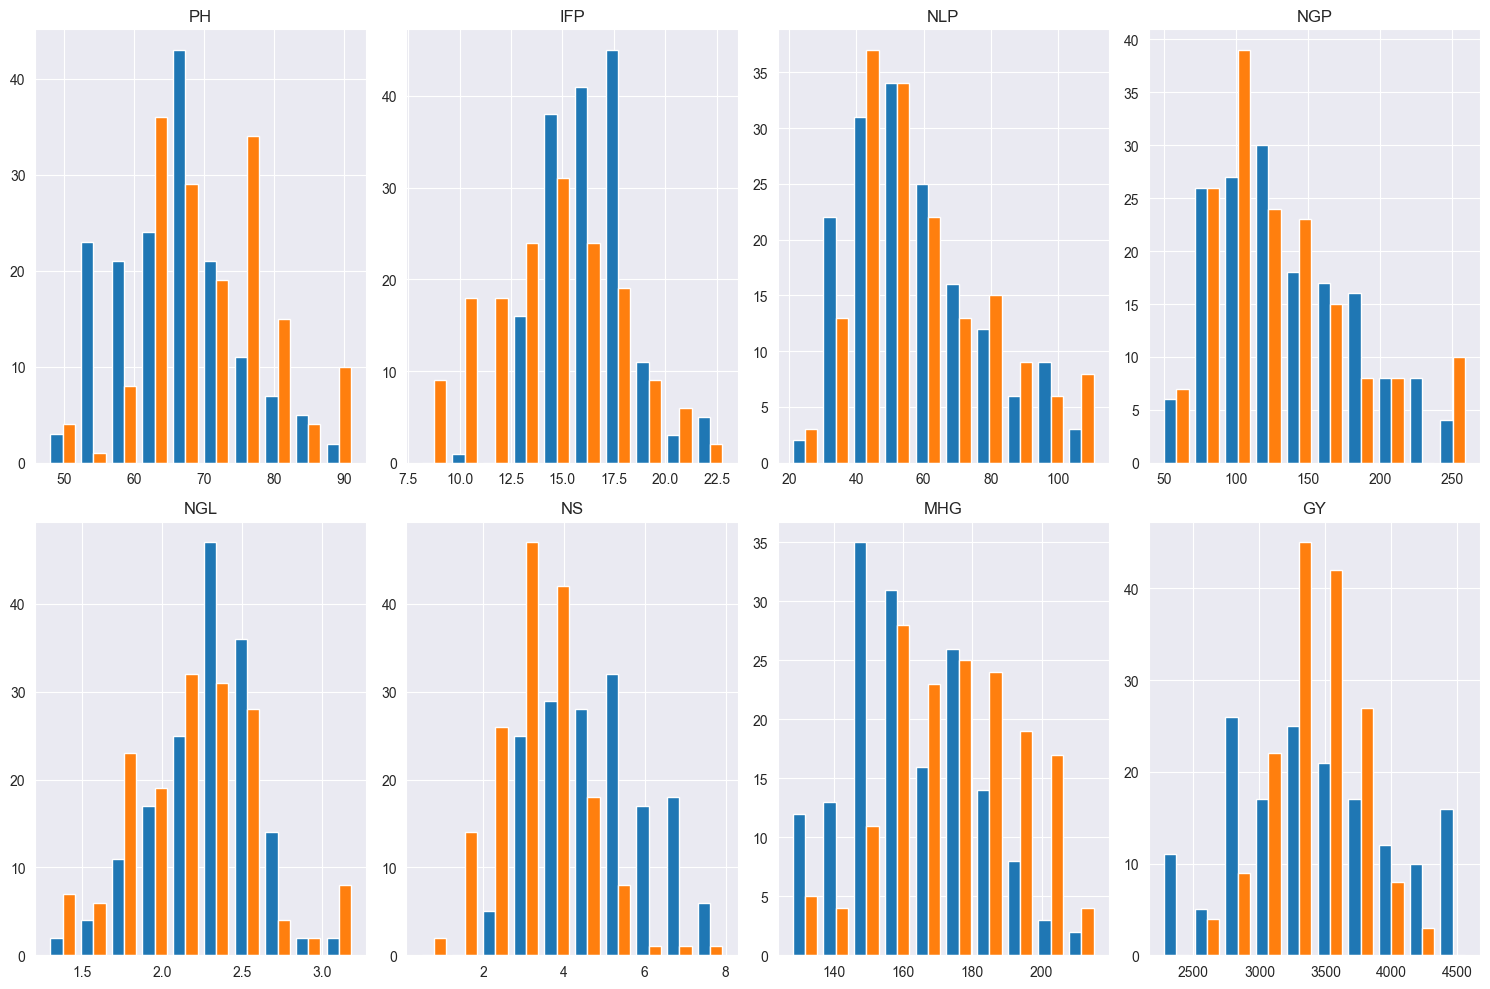

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
cnt = 0
for i in range(2):
    for j in range(4):
        axs[i, j].hist([season1[float_cols.tolist()[cnt]], season2[float_cols.tolist()[cnt]]])
        axs[i, j].set_title(float_cols.tolist()[cnt])
        cnt += 1
fig.tight_layout()
plt.show()

Next I want to see of there's a statistical difference between the two different seasons, so I will apply a z tes. Furthermore we may check the distribution for each season and each distribution.

<Axes: >

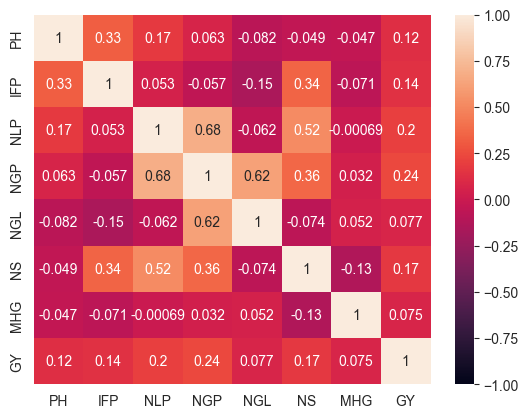

In [9]:
sns.heatmap(data[float_cols].corr(), annot=True, vmin=-1, vmax=1)

array([[<Axes: xlabel='PH', ylabel='PH'>,
        <Axes: xlabel='IFP', ylabel='PH'>,
        <Axes: xlabel='NLP', ylabel='PH'>,
        <Axes: xlabel='NGP', ylabel='PH'>,
        <Axes: xlabel='NGL', ylabel='PH'>,
        <Axes: xlabel='NS', ylabel='PH'>,
        <Axes: xlabel='MHG', ylabel='PH'>,
        <Axes: xlabel='GY', ylabel='PH'>],
       [<Axes: xlabel='PH', ylabel='IFP'>,
        <Axes: xlabel='IFP', ylabel='IFP'>,
        <Axes: xlabel='NLP', ylabel='IFP'>,
        <Axes: xlabel='NGP', ylabel='IFP'>,
        <Axes: xlabel='NGL', ylabel='IFP'>,
        <Axes: xlabel='NS', ylabel='IFP'>,
        <Axes: xlabel='MHG', ylabel='IFP'>,
        <Axes: xlabel='GY', ylabel='IFP'>],
       [<Axes: xlabel='PH', ylabel='NLP'>,
        <Axes: xlabel='IFP', ylabel='NLP'>,
        <Axes: xlabel='NLP', ylabel='NLP'>,
        <Axes: xlabel='NGP', ylabel='NLP'>,
        <Axes: xlabel='NGL', ylabel='NLP'>,
        <Axes: xlabel='NS', ylabel='NLP'>,
        <Axes: xlabel='MHG', ylabel='NLP'>,
  

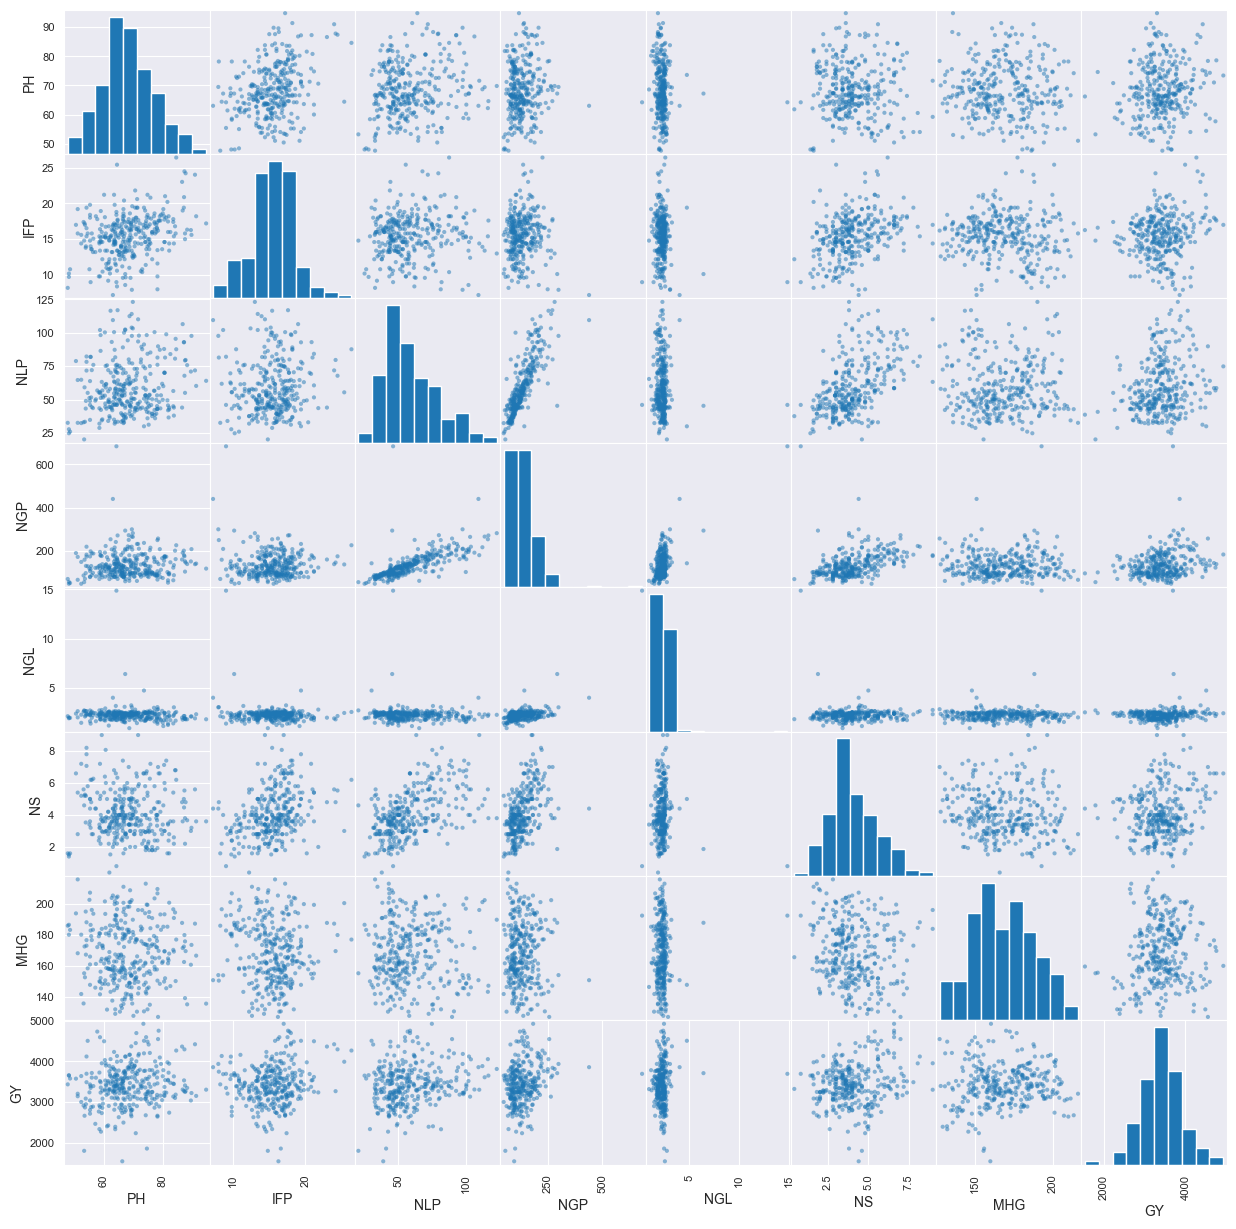

In [11]:
scatter_matrix(data[float_cols], figsize=(15,15))

As expected there is a correlation between the number of grains per plant (NGP) and number of legumes per plant (NLP) and between number of stems (NS) and number of legumes per plant (NLP).

array([[<Axes: xlabel='NGP', ylabel='NGP'>,
        <Axes: xlabel='NLP', ylabel='NGP'>,
        <Axes: xlabel='NS', ylabel='NGP'>],
       [<Axes: xlabel='NGP', ylabel='NLP'>,
        <Axes: xlabel='NLP', ylabel='NLP'>,
        <Axes: xlabel='NS', ylabel='NLP'>],
       [<Axes: xlabel='NGP', ylabel='NS'>,
        <Axes: xlabel='NLP', ylabel='NS'>,
        <Axes: xlabel='NS', ylabel='NS'>]], dtype=object)

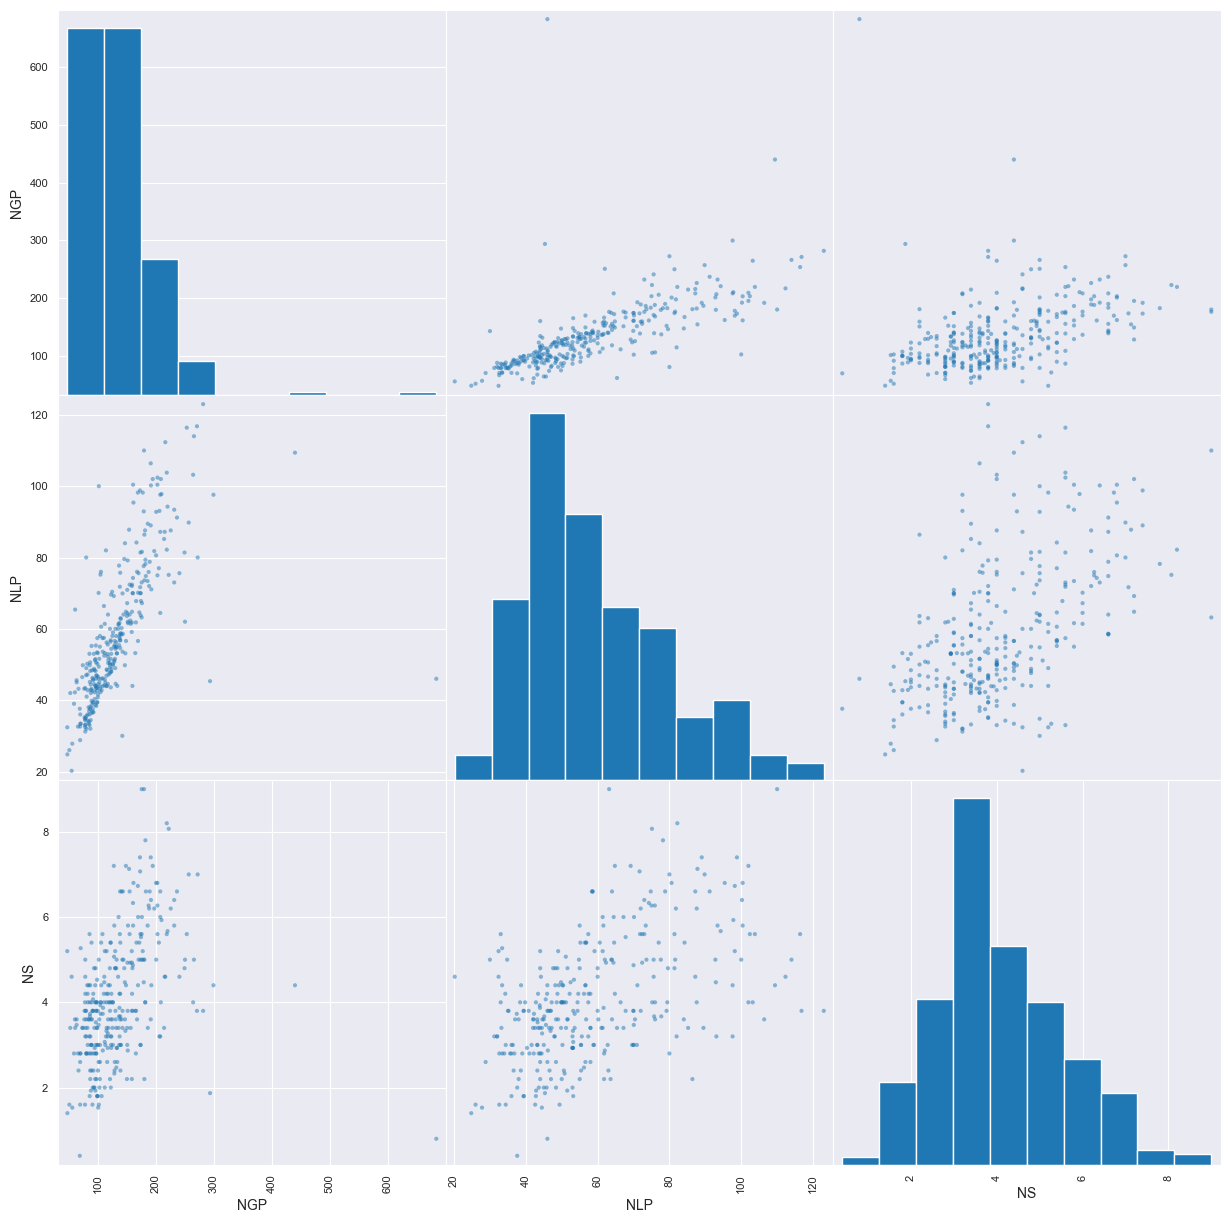

In [10]:
scatter_matrix(data[["NGP", "NLP", "NS"]], figsize=(15,15))

It's clear that there is a linear relationship between NS & NLP, NS & NGP, NGP & NLP, so we need to get more insight of these relationships. In order to find other correlations we need to remove the outliers.

In [25]:
correlation, pvalue = pearsonr(data['NLP'], data['NGP'])
print(correlation, pvalue, pvalue < 0.05)

0.8161197801611539 1.0069184152002714e-77 True


In [26]:
correlation, pvalue = pearsonr(data['NS'], data['NGP'])
print(correlation, pvalue, pvalue < 0.05)

0.5040402480780506 5.061261850067122e-22 True


In [27]:
correlation, pvalue = pearsonr(data['NS'], data['NLP'])
print(correlation, pvalue, pvalue < 0.05)

0.5281939689440748 2.172326159042103e-24 True


In [30]:
NON_MHG = [x for x in float_cols if x != '']

In [35]:
for col in NON_MHG:
    correlation, pvalue = pearsonr(data[col], data['MHG'])
    print(col, correlation, pvalue, pvalue < 0.05)


PH -0.04480857156158237 0.4243920839589844 False
IFP -0.08263715460953834 0.14021325499630322 False
NLP -0.0017089306938236218 0.975707632036019 False
NGP 0.014055882807646906 0.8022256840419104 False
NGL -0.014765058811269039 0.7924687668104496 False
NS -0.1365003733368234 0.014538079472121357 True
GY 0.0724533038033575 0.1961107855268036 False


In [36]:
for col in NON_MHG:
    correlation, pvalue = spearmanr(data[col], data['MHG'])
    print(col, correlation, pvalue, pvalue < 0.05)

PH -0.03178812459809405 0.5710123435697454 False
IFP -0.08888170539212563 0.11253881878003671 False
NLP 0.022361768953113065 0.6902587626642653 False
NGP 0.027614364263550076 0.6226192875272015 False
NGL -0.015012476104596177 0.7890722857616599 False
NS -0.15408021398081825 0.005744903848841926 True
GY 0.08096586643556554 0.14843905887960746 False


In [37]:
for col in NON_MHG:
    correlation, pvalue = kendalltau(data[col], data['MHG'])
    print(col, correlation, pvalue, pvalue < 0.05)


PH -0.02254344870316335 0.5483258783572478 False
IFP -0.05758092465903499 0.1271207829286756 False
NLP 0.021977180184338006 0.5581311747695947 False
NGP 0.019554203504621764 0.6021548167827331 False
NGL -0.012573526584747799 0.7382736245492906 False
NS -0.10348163857614275 0.006476941806326294 True
GY 0.05283788086268395 0.15864544683427595 False


In [41]:
f_classif(data[NON_MHG], data['MHG'])

(array([0.75944443, 2.03774635, 2.87480641, 1.73635529, 0.58529442,
        0.62548636, 0.35971456]),
 array([0.76572017, 0.13739994, 0.05355923, 0.20243466, 0.90437654,
        0.87568654, 0.99446824]))

In [14]:
data = clip_outliers(data)

<Axes: >

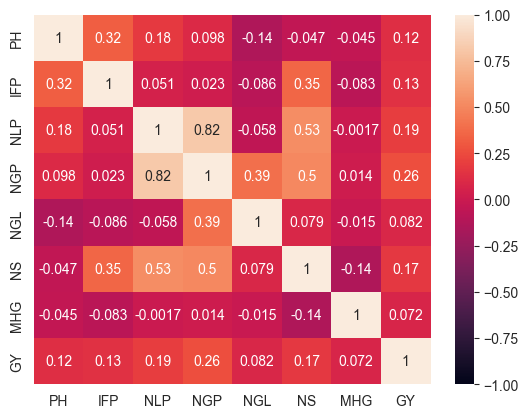

In [15]:
sns.heatmap(data[float_cols].corr(), annot=True, vmin=-1, vmax=1)

array([[<Axes: xlabel='PH', ylabel='PH'>,
        <Axes: xlabel='IFP', ylabel='PH'>,
        <Axes: xlabel='NLP', ylabel='PH'>,
        <Axes: xlabel='NGP', ylabel='PH'>,
        <Axes: xlabel='NGL', ylabel='PH'>,
        <Axes: xlabel='NS', ylabel='PH'>,
        <Axes: xlabel='MHG', ylabel='PH'>,
        <Axes: xlabel='GY', ylabel='PH'>],
       [<Axes: xlabel='PH', ylabel='IFP'>,
        <Axes: xlabel='IFP', ylabel='IFP'>,
        <Axes: xlabel='NLP', ylabel='IFP'>,
        <Axes: xlabel='NGP', ylabel='IFP'>,
        <Axes: xlabel='NGL', ylabel='IFP'>,
        <Axes: xlabel='NS', ylabel='IFP'>,
        <Axes: xlabel='MHG', ylabel='IFP'>,
        <Axes: xlabel='GY', ylabel='IFP'>],
       [<Axes: xlabel='PH', ylabel='NLP'>,
        <Axes: xlabel='IFP', ylabel='NLP'>,
        <Axes: xlabel='NLP', ylabel='NLP'>,
        <Axes: xlabel='NGP', ylabel='NLP'>,
        <Axes: xlabel='NGL', ylabel='NLP'>,
        <Axes: xlabel='NS', ylabel='NLP'>,
        <Axes: xlabel='MHG', ylabel='NLP'>,
  

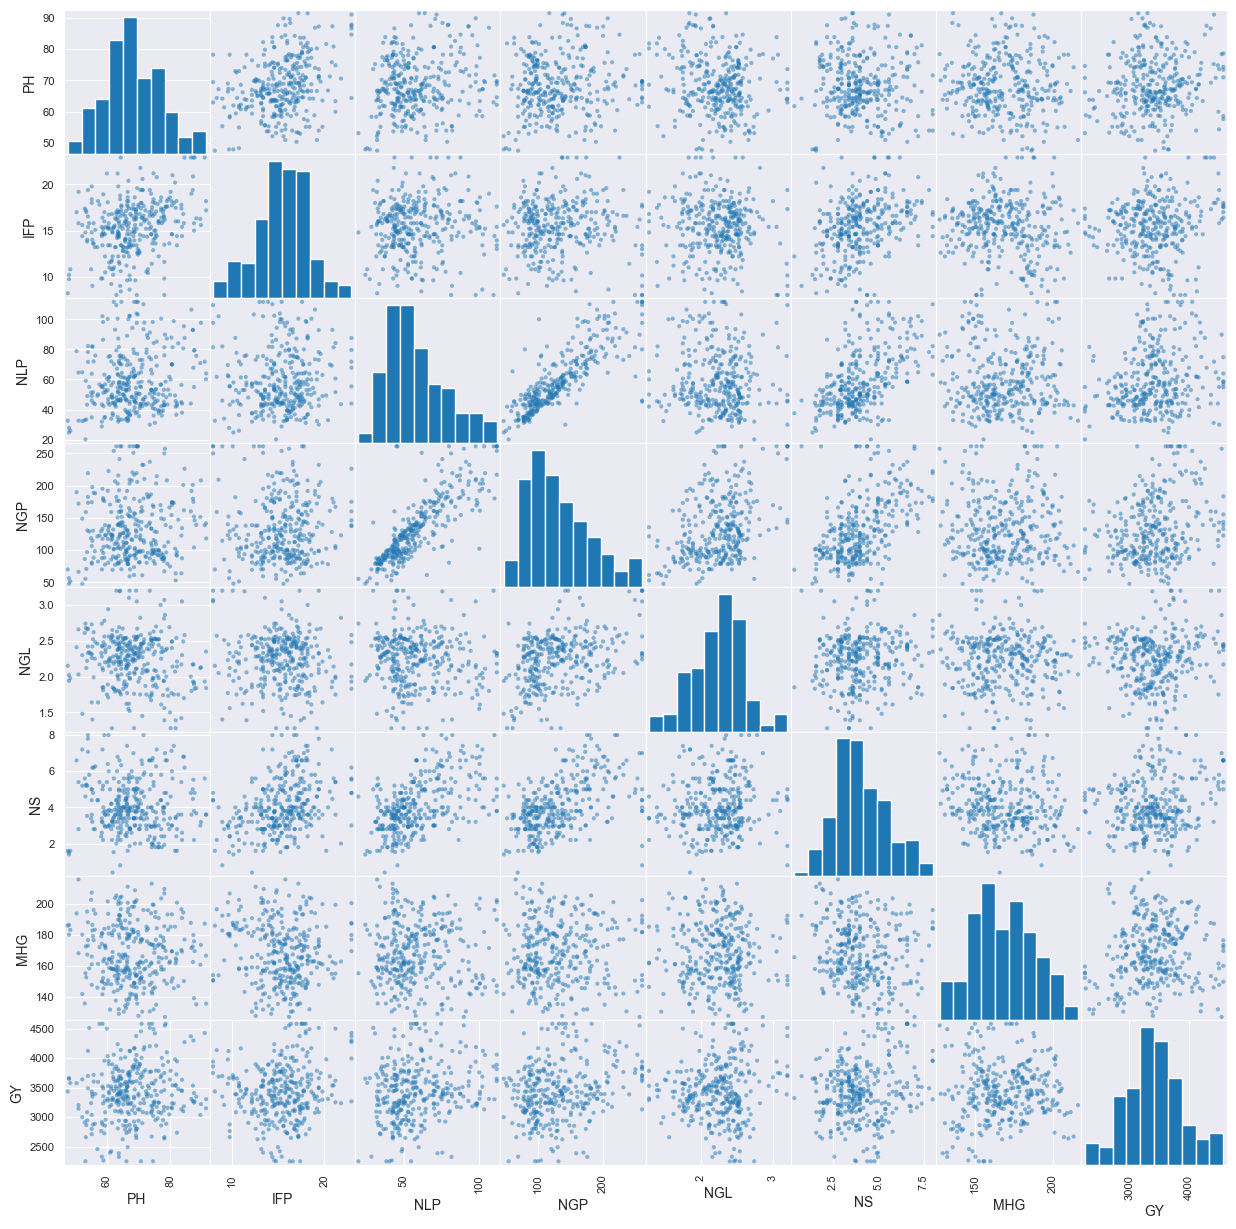

In [17]:
scatter_matrix(data[float_cols], figsize=(15,15))

Removing outliers exposed a strong linear correlation between NLP & NGP, NS & NGP.

# Feature engineering

# Exploratory Data Analysis